# Nationwide Diversity and Integration

This notebook pulls together the main features of the `censusdis` and
`divintseg` projects to demonstrate how quickly and easily we can 

1. Identify US Census data variables. 
    - We will use metadata calls to identify 16 race and ethnicity variables.
2. Download the variables for the entire country at the block group level. 
    - There are almost 240,000 census block groups in the 50 states and DC.
    - We will download all 16 variables for all of them.
3. Compute diversity and integration metrics at the census tract level.
    - There are over 84,000 census tracts in the 50 states and DC.
    - Integration expresses how integrated the block groups within a tract are.
4. Attach geography bounds to all the census tracts.
    - This process will transparently download and cache census map data
      on a state by state basis. 
    - `censusdis` will determine how to do this
      and manage the process. No user input is required.
5. Download state boundaries.
    - This is simply to make our final maps look better.
6. Plot maps showing nationwide diversity and integration.
    - Data is plotted at the census tract level.
    - Alaska and Hawaii are automatically relocated on the map to better use output real estate.
    - The state boundaries are plotted to make the maps more readable.
7. Determine which regions of the country have most concentrated
   number of the most and least diverse and integrated tracts.
   - We compute the top and bottom 10% of each metric.
   - We scatter plot them on maps.
    
Even in a fresh python environment with no data pre-cached locally, this entire process can
be run on a fairly standard laptop with a high-speed internet connection in a just a few minutes.

For more details, please refer to the README files and other documentation in the 
[`censusdis`](https://github.com/vengroff/censusdis) 
and 
[`divintseg`](https://github.com/vengroff/divintseg)
projects.

## 0. Imports and configuration

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC

import divintseg as dis

In [3]:
# Fill in your own key here, or leave as is
# if you are doing low volume queries that
# will not hit the census server usage limits.
CENSUS_API_KEY = None

## 1. Identify the dataset and variables we will use

In [4]:
DATASET = "acs/acs5"
YEAR = 2020

In [5]:
GROUP = "B03002"

In [6]:
leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

In [7]:
len(leaves)

16

## 2. Download the data

In [8]:
%%time

df_bg = ced.download_detail(
    DATASET,
    YEAR,
    leaves,
    state=ALL_STATES_AND_DC,
    block_group="*",
    api_key=CENSUS_API_KEY,
)

CPU times: user 1.37 s, sys: 164 ms, total: 1.54 s
Wall time: 19.6 s


In [9]:
df_bg.shape

(239780, 20)

## 3. Compute diversity and integration

In [10]:
%%time

df_di = dis.di(
    df_bg,
    by=["STATE", "COUNTY", "TRACT"],
    over="BLOCK_GROUP",
).reset_index()

CPU times: user 1min 13s, sys: 980 ms, total: 1min 14s
Wall time: 1min 22s


In [11]:
df_di.shape

(84414, 5)

## 4. Infer the geographies so we can plot

In [12]:
%%time

gdf_di = ced.add_inferred_geography(df_di, YEAR)

CPU times: user 3.02 s, sys: 99.3 ms, total: 3.12 s
Wall time: 3.12 s


## 5. Get state boundaries for the plots

In [13]:
%%time

gdf_states = cem.ShapeReader(year=YEAR).read_cb_shapefile("us", "state")

gdf_states = gdf_states[gdf_states.STATEFP.isin(ALL_STATES_AND_DC)]

CPU times: user 68 ms, sys: 4.63 ms, total: 72.6 ms
Wall time: 71.2 ms


## 6. Plot diversity and integration

CPU times: user 21.2 s, sys: 319 ms, total: 21.6 s
Wall time: 21.9 s


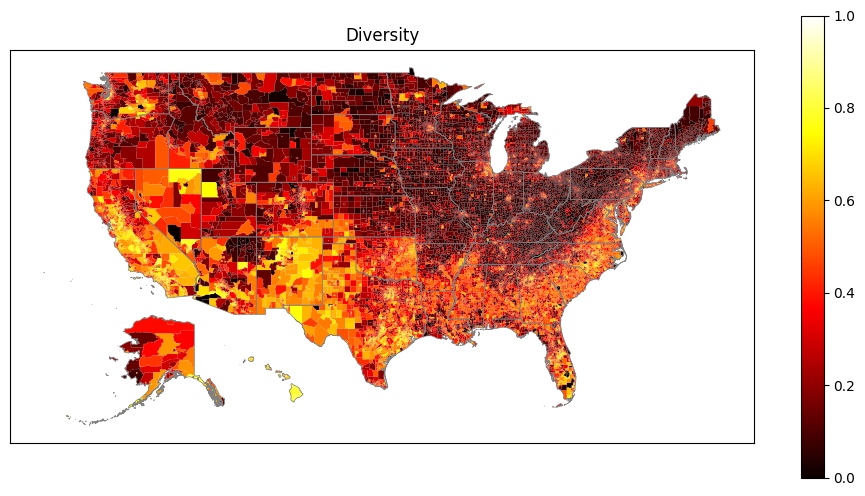

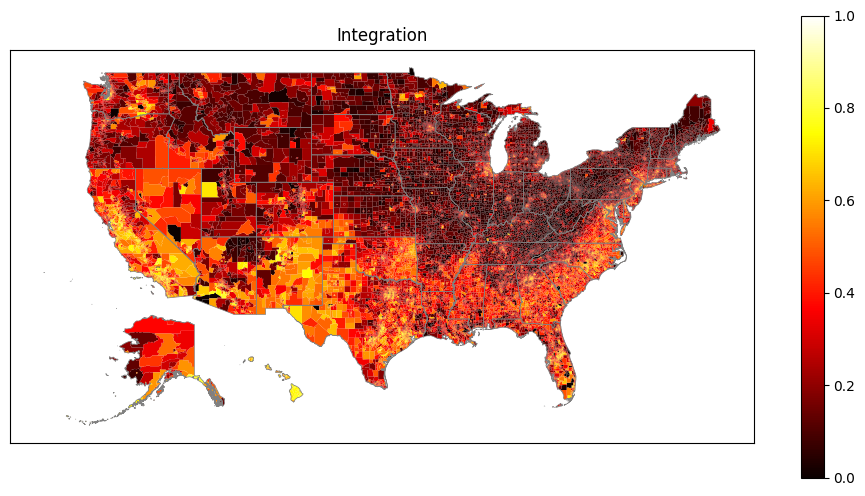

In [14]:
%%time

for col in ["diversity", "integration"]:
    ax = cem.plot_us(
        gdf_di[gdf_di.geometry != None],
        col,
        cmap="hot",
        legend=True,
        figsize=(12, 6),
        vmin=0.0,
        vmax=1.0,
    )

    ax = cem.plot_us_boundary(gdf_states, edgecolor="gray", linewidth=0.5, ax=ax)

    ax.set_title(col.title())

    ax.tick_params(
        left=False,
        right=False,
        bottom=False,
        labelleft=False,
        labelbottom=False,
    )

## 7. What are the top and bottom 10%?

In [15]:
%%time

n = len(gdf_di.index)

gdf_di_top_d = gdf_di.nlargest(n // 10, "diversity")
gdf_di_bottom_d = gdf_di.nsmallest(n // 10, "diversity")

gdf_di_top_i = gdf_di.nlargest(n // 10, "integration")
gdf_di_bottom_i = gdf_di.nsmallest(n // 10, "integration")

gdf_di_centroids = gdf_di.copy()

gdf_random_sample = gdf_di.sample(n=n // 10, random_state=17)

CPU times: user 40.8 ms, sys: 3.81 ms, total: 44.7 ms
Wall time: 44.1 ms


In [16]:
%%time

# Compute the geometry to centroid points to make the plot
# more readable.

gdf_di_top_d.geometry = cem.geographic_centroids(gdf_di_top_d)
gdf_di_bottom_d.geometry = cem.geographic_centroids(gdf_di_bottom_d)

gdf_di_top_i.geometry = cem.geographic_centroids(gdf_di_top_i)
gdf_di_bottom_i.geometry = cem.geographic_centroids(gdf_di_bottom_i)

gdf_di_centroids.geometry = cem.geographic_centroids(gdf_di_centroids)

gdf_random_sample.geometry = cem.geographic_centroids(gdf_random_sample)

CPU times: user 12.2 s, sys: 165 ms, total: 12.3 s
Wall time: 12.4 s


In [17]:
def plot_top_or_bottom(
    gdf,
    metric_description: str,
    top_or_bottom: str = "top",
):
    """
    A helper plot routine.

    Covers most of the repetitive boilerplate that we don't
    want to deal with typing more than once.
    """

    # Plot configuration.

    top_color = "#0343df"
    bottom_color = "#E50000"
    random_color = "#74216f"

    markersize = 1

    state_linewidth = 0.5
    state_edgecolor = "gray"

    all_color = "lightgray"

    figsize = (12, 6)

    # Actual plotting.

    # State bounds
    ax = cem.plot_us_boundary(
        gdf_states,
        edgecolor=state_edgecolor,
        linewidth=state_linewidth,
        figsize=figsize,
    )

    # All tracts in a background color
    cem.plot_us(
        gdf_di_centroids[gdf_di_centroids.geometry != None],
        markersize=markersize,
        color=all_color,
        ax=ax,
    )

    # The sample we want to emphasize
    cem.plot_us(
        gdf[gdf.geometry != None],
        markersize=markersize,
        color=top_color
        if top_or_bottom == "top"
        else (bottom_color if top_or_bottom == "bottom" else random_color),
        ax=ax,
    )

    if top_or_bottom == "top":
        ax.set_title(
            f"Top 10% Most {metric_description.title()} Census Tracts (n = {len(gdf.index)})"
        )
    elif top_or_bottom == "bottom":
        ax.set_title(
            f"Bottom 10% Least {metric_description.title()} Census Tracts (n = {len(gdf.index)})"
        )
    else:
        ax.set_title(f"Random 10% Sample of Census Tracts (n = {len(gdf.index)})")

    ax.tick_params(
        left=False,
        right=False,
        bottom=False,
        labelleft=False,
        labelbottom=False,
    )

#### Random 10% Sample

The purpose of this first plot is to show us what the distribution of a random 10%
sample looks like. Then we can see if our top and bottom 10% look at all like this
or if they are concentrated in regions according to some different kind of spatial
distribution.

CPU times: user 3.99 s, sys: 39.5 ms, total: 4.03 s
Wall time: 3.51 s


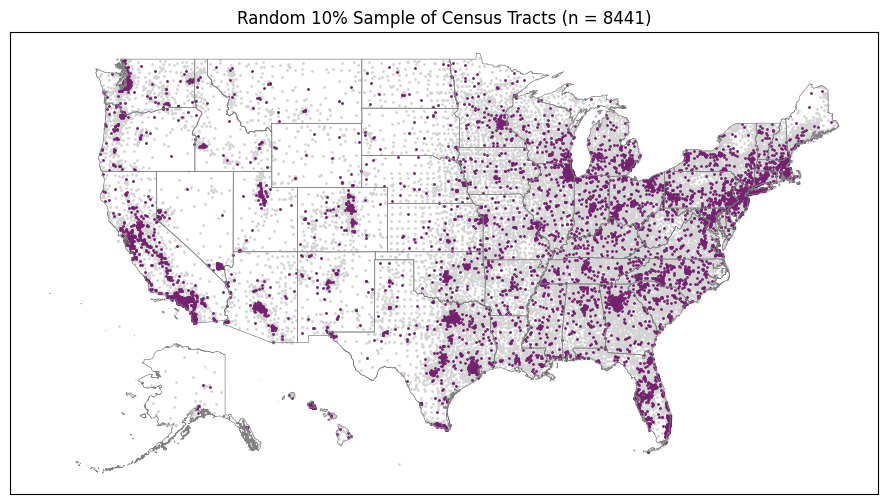

In [18]:
%%time
plot_top_or_bottom(gdf_random_sample, "", top_or_bottom="random")

CPU times: user 3.97 s, sys: 38 ms, total: 4.01 s
Wall time: 3.48 s


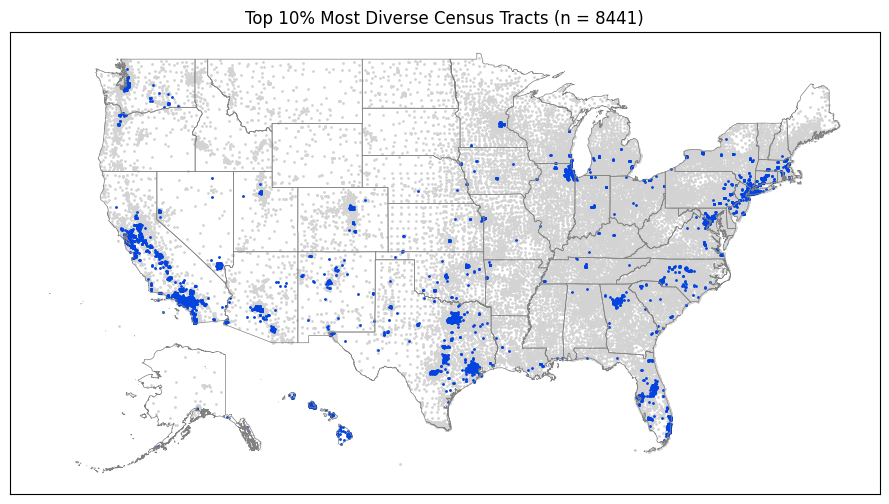

In [19]:
%%time
plot_top_or_bottom(gdf_di_top_d, "Diverse")

CPU times: user 3.95 s, sys: 37.7 ms, total: 3.99 s
Wall time: 3.46 s


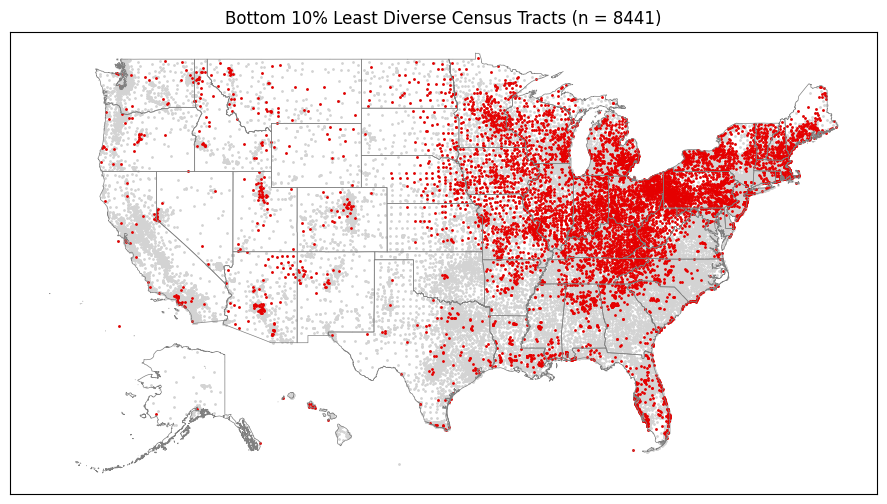

In [20]:
%%time
plot_top_or_bottom(gdf_di_bottom_d, "Diverse", top_or_bottom="bottom")

CPU times: user 3.98 s, sys: 35.4 ms, total: 4.02 s
Wall time: 3.49 s


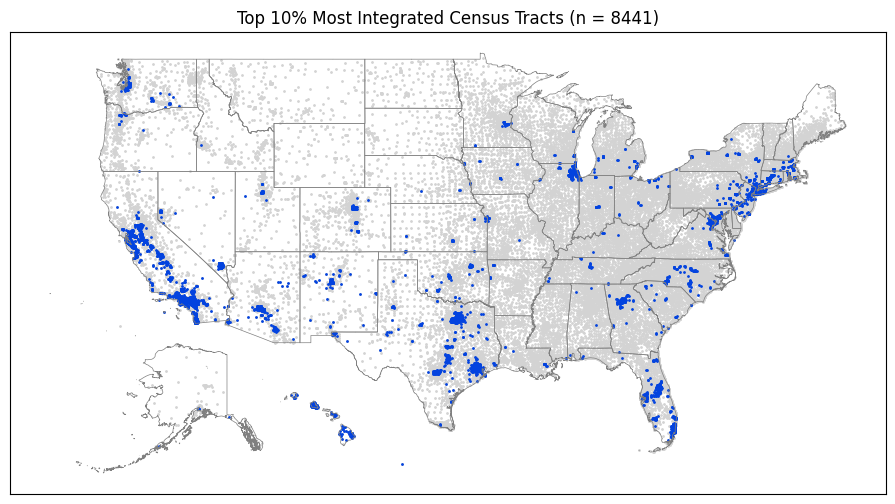

In [21]:
%%time
plot_top_or_bottom(gdf_di_top_i, "Integrated")

CPU times: user 4.08 s, sys: 29.3 ms, total: 4.11 s
Wall time: 3.58 s


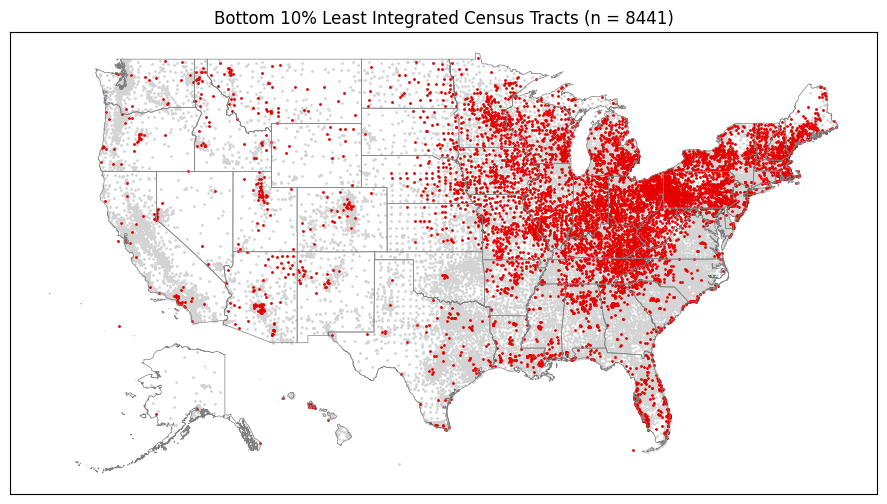

In [22]:
%%time
plot_top_or_bottom(gdf_di_bottom_i, "Integrated", top_or_bottom="bottom")